ΕΡΓΑΣΙΑ ΤΕΛΙΚΗ  
ΚΥΡΙΑΚΟΥ ΧΡΗΣΤΟΣ SDI2300096
ΣΑΡΡΗΣ ΓΕΩΡΓΙΟΣ ΝΙΚΟΛΑΟΣ SDI2300181
ΙΩΑΝΝΗΣ ΖΩΓΡΑΦΟΣ SDI2300050
Επεξεργαστήκαμε 5 κατηγορίες προϊόντων, εφαρμόζοντας καθαρισμό, clustering, ανάλυση συναισθήματος και σύστημα συστάσεων. Το sentiment score βασίζεται σε VADER και κανονικοποιημένα ratings, ενώ το clustering έγινε με KMeans και TF-IDF. Η ταξινόμηση συναισθήματος έγινε με Naive Bayes, KNN και Random Forest, με αξιολόγηση μέσω 10-fold CV. Το σύστημα συστάσεων βασισμένο στο περιεχόμενο είναι λειτουργικό, ενώ η συνεργατική φιλτράρισή βρίσκεται σε εξέλιξη. Εκκρεμεί η προσθήκη του Apriori και η βελτίωση των προβλέψεων για αρνητικά reviews.

In [1]:
import nltk
nltk.download('stopwords')
nltk.download('vader_lexicon')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\chris\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\chris\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [2]:
import os
import json
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk import download
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import(
    classification_report,
    confusion_matrix,
    accuracy_score,
    make_scorer,
    precision_score,
    recall_score,
    f1_score
)
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import silhouette_score
from scipy.sparse import hstack, csr_matrix

# Κατεβάζουμε τα λεξικά του NLTK
nltk.download('stopwords')
nltk.download('vader_lexicon')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\chris\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\chris\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [3]:
stop_words=set(stopwords.words('english')) #Δημιουργούμε το σύνολο των stopwords για αγγλικά όπως the,is,and 
stemmer=PorterStemmer() #Αρχικοποιούμε έναν stemmer για να κάνουμε stemming 

def preprocess_text(text):
    if not isinstance(text,str):
        return ""  #Αν η είσοδος δεν είναι string,επιστρέφουμε κενό
    text=text.lower() #Μετατρέπουμε όλο το κείμενο σε πεζά γράμματα 
    text=re.sub(r"[^a-z0-9\s]","",text)   #Αφαιρούμε όλους τους χαρακτήρες εκτός από γράμματα,αριθμούς και κενά
    tokens=text.split() #Διαχωρίζουμε το κείμενο σε λέξεις
    return " ".join([stemmer.stem(w) for w in tokens if w not in stop_words]) # Επιστρέφουμε το κείμενο με τα tokens μετά από stemming, αφαιρώντας και τα stopwords


In [4]:
def read_jsonl(path,max_rows=None): 
    data=[] #Αρχικοποιούμε μία κενή λίστα για να αποθηκεύσουμε τα δεδομένα JSON
    with open(path,'r',encoding='utf-8') as f:  # Ανοίγουμε το αρχείο jsonl σε λειτουργία ανάγνωσης με UTF-8 encoding
        for i,line in enumerate(f): #Διαβάζουμε κάθε γραμμή του αρχείου (η κάθε γραμμή είναι ένα JSON αντικείμενο)
            if max_rows and i >= max_rows: #Αν έχει δοθεί όριο max_rows, σταματάμε όταν το φτάσουμε
                break
            data.append(json.loads(line)) #Μετατρέπουμε τη γραμμή JSON (string) σε λεξικό και το προσθέτουμε στη λίστα
    return pd.DataFrame(data) #Επιστρέφουμε τα δεδομένα ως pandas DataFrame


def convert_jsonl_to_csv(review_path,meta_path,output_path,max_rows=5000):
    print(f"Reading reviews from {review_path}") #Εμφανίζει το μονοπάτι του αρχείου αξιολογήσεων που πρόκειται να διαβαστεί
    df_reviews=read_jsonl(review_path, max_rows) #Διαβάζει το review αρχείο JSONL
    #Εμφανίζει το μονοπάτι του αρχείου με τα μεταδεδομένα (meta)
    print(f"Reading meta data from {meta_path}")
    df_meta = read_jsonl(meta_path)   #Διαβάζει το αρχείο meta JSONL
    #Εκτυπώνει πόσες εγγραφές φορτώθηκαν από τα δύο αρχεία
    print(f"Reviews loaded:{len(df_reviews)},Meta data loaded:{len(df_meta)}")
    #Εκτυπώνει πόσες εγγραφές φορτώθηκαν από τα δύο αρχεία
    if 'asin' not in df_reviews.columns or 'parent_asin' not in df_meta.columns:
        print("[!] Skipping: 'asin' or 'parent_asin' column missing.")
        return  #Τερματισμός αν λείπει κάποια στήλη
    df_meta['asin']=df_meta['parent_asin'] #Προσθέτει στήλη 'asin' στο meta με τιμή ίση με 'parent_asin', ώστε να γίνει merge
    df_merged=pd.merge(df_reviews,df_meta,on='asin',how='left')    #Κάνει merge τις αξιολογήσεις με τα μεταδεδομένα με βάση την κοινή στήλη 'asin'

    if df_merged.empty:  #Αν το αποτέλεσμα είναι άδειο, δεν προχωρά
        print("[!] Skipping: empty merged dataframe")
        return
    #Αποθηκεύει τα ενοποιημένα δεδομένα σε CSV αρχείο
    df_merged.to_csv(output_path, index=False)
    print(f"Saved {len(df_merged)} merged rows to {output_path}")


In [5]:
def clean_dataframe(df):
    #Ελέγχει αν υπάρχει κάποια από τις στήλες που περιέχουν κείμενο αξιολόγησης
    for col in ['text','reviewText','review_text']:
        if col in df.columns:
            df['review_text']=df[col]
            break
    else:
        #Αν δεν βρεθεί καμία κατάλληλη στήλη, εμφανίζει μήνυμα σφάλματος
        print("ERROR! Missing review text")
        return None

    #Ελέγχει αν υπάρχει κάποια από τις στήλες που περιέχουν τίτλο αξιολόγησης
    for col in ['title','summary','title_x','Title','review_title']:
        if col in df.columns:
            df['review_title']=df[col]
            break
    else:
        #Αν δεν βρεθεί καμία κατάλληλη στήλη, εμφανίζει μήνυμα σφάλματος
        print("ERROR! Missing review title")
        return None

    #Ελέγχει αν υπάρχει κάποια από τις στήλες που περιέχουν βαθμολογία αξιολόγησης
    for col in ['rating','overall','review_rating']:
        if col in df.columns:
            df['review_rating']=df[col]
            break
    else:
        #Αν δεν βρεθεί καμία κατάλληλη στήλη, εμφανίζει μήνυμα σφάλματος
        print("ERROR! Missing rating")
        return None

    #Δημιουργεί νέο DataFrame με τις τρεις βασικές στήλες
    df_clean=df[['review_rating', 'review_title', 'review_text']].copy()
    #Αφαιρεί γραμμές με κενά πεδία
    df_clean=df_clean.dropna()
    #Μετατρέπει το κείμενο σε πεζά γράμματα για ομοιομορφία
    df_clean['review_text']=df_clean['review_text'].astype(str).str.lower()
    df_clean['review_title']=df_clean['review_title'].astype(str).str.lower()

    #Επιστρέφει το καθαρισμένο DataFrame
    return df_clean



In [6]:
# Αρχικοποίηση του sentiment analyzer
vader=SentimentIntensityAnalyzer()

def compute_sentiment_score(text:str,rating:float,w1=0.6,w2=0.4)->float:
    if not isinstance(text,str):
        text=""

    # Υπολογισμός sentiment με χρήση VADER
    sentiment=vader.polarity_scores(text)["compound"]

    # Κανονικοποίηση βαθμολογίας και sentiment
    normalized_rating=(rating-1)/4
    normalized_sentiment=(sentiment+1)/2

    # Συνδυαστικό σκορ βάσει βαρών
    final_score=w1*normalized_sentiment+w2*normalized_rating

    return round(final_score,4)


In [7]:
#Συνάρτηση για σχεδίαση της κατανομής των βαθμολογιών ανά κατηγορία
def plot_ratings_dist(df,category):
    plt.figure(figsize=(6,4))  #Ορισμός μεγέθους γραφήματος
    sns.histplot(df['review_rating'],bins=5,kde=False,color='black')  #Ιστόγραμμα με 5 διαστήματα (1-5)
    plt.title("Rating Distribution of: "+category)  #Τίτλος διαγράμματος
    plt.ylabel("Count")  #Ετικέτα άξονα y
    plt.xlabel("Rating")  #Ετικέτα άξονα x
    plt.tight_layout()  #Αυτόματη τακτοποίηση layout
    plt.show()  #Εμφάνιση γραφήματος


In [8]:
def preprocess_text(text):
    if not isinstance(text, str):
        return ""  # Επιστρέφει κενό αν δεν είναι συμβολοσειρά

    text = text.lower()  # Μετατροπή σε πεζά
    text = re.sub(r"[^a-z0-9\s]", "", text)  # Αφαίρεση σημείων στίξης και ειδικών χαρακτήρων
    tokens = text.split()  # Διαχωρισμός σε λέξεις
    tokens = [PorterStemmer().stem(w) for w in tokens if w not in stopwords.words('english')]  # Αφαίρεση stopwords + stemming
    return " ".join(tokens)  # Επιστροφή ενιαίου string με τις επεξεργασμένες λέξεις


def cluster_products(df,category_name,max_features=1000,k_clusters=5):
    print(f"Clustering for category:{category_name}")

    # Εφαρμόζει προεπεξεργασία στο κείμενο κάθε κριτικής
    df['processed_text']=df['review_text'].apply(preprocess_text)

    # Μετατροπή των περιγραφών σε διανύσματα με TF-IDF
    tfidf=TfidfVectorizer(max_features=max_features)
    tfidf_matrix=tfidf.fit_transform(df['processed_text'])

    # Κανονικοποίηση των αριθμητικών χαρακτηριστικών
    scaler=StandardScaler()
    numeric_scaled=scaler.fit_transform(df[['review_rating']])

    # Ενοποίηση των χαρακτηριστικών (κειμένου + αριθμητικών)
    feature_matrix=hstack([tfidf_matrix, numeric_scaled])
    feature_matrix=feature_matrix.tocsr()  # απαραίτητο για slicing πιο κάτω

    # Υπολογίζει την παραμόρφωση (inertia) για διάφορα k
    distortions=[]
    K=range(2, 10)
    for k in K:
        kmeans=KMeans(n_clusters=k,random_state=42)
        kmeans.fit(feature_matrix)
        distortions.append(kmeans.inertia_)

    # Εμφάνιση του elbow plot
    plt.figure(figsize=(6,4))
    plt.plot(K, distortions,'bx-')
    plt.xlabel('k')
    plt.ylabel('Distortion')
    plt.title(f'{category_name}-Elbow Method')
    plt.tight_layout()
    plt.show()

    # Εκτελεί τελικό clustering με το επιλεγμένο k
    kmeans = KMeans(n_clusters=k_clusters, random_state=42)
    labels = kmeans.fit_predict(feature_matrix)
    df['cluster'] = labels  #Επιστρέφει το label κάθε δείγματος

    # Μείωση διάστασης για οπτικοποίηση σε 2D 
    pca=PCA(n_components=2)
    reduced=pca.fit_transform(feature_matrix[:2000].toarray()) #περιορίζεται για ταχύτητα

    #Σχεδιάζει την οπτικοποίηση των clusters
    plt.figure(figsize=(6,5))
    plt.scatter(reduced[:,0], reduced[:,1],c=labels[:2000],cmap='tab10')
    plt.title(f'{category_name}-PCA Cluster Visualization')
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.colorbar(label='Cluster')
    plt.tight_layout()
    plt.show()
    #Υπολογισμός Silhouette Score για αξιολόγηση ποιότητας ομαδοποίησης
    score=silhouette_score(feature_matrix,labels)
    print(f"Silhouette Score for{category_name}:{round(score,4)}")
    return df

In [9]:
def content_based_recommendations(df, input_index, top_k=5):
    if not all(col in df.columns for col in ['review_title', 'review_text', 'sentiment_score']):
        print("[!] Το dataset πρέπει να περιέχει review_title, review_text και sentiment_score.")
        return pd.DataFrame()

    df = df.dropna(subset=['review_text']).copy().reset_index(drop=True)
    df['combined_text']=df['review_title'].fillna('')+ " " +df['review_text'].fillna('')

    # TF-IDF μετατροπή
    tfidf=TfidfVectorizer(max_features=300)
    tfidf_matrix=tfidf.fit_transform(df['combined_text'])

    # Προσθήκη sentiment ως feature
    sentiment_scaled=MinMaxScaler().fit_transform(df[['sentiment_score']])
    sentiment_sparse=csr_matrix(sentiment_scaled)

    final_features=hstack([tfidf_matrix, sentiment_sparse])

    if input_index<0 or input_index>=len(df):
        print("[!] Το index είναι εκτός ορίων.")
        return pd.DataFrame()

    similarities=cosine_similarity(final_features[input_index],final_features).flatten()
    top_indices=similarities.argsort()[::-1][1:top_k + 1]

    return df.iloc[top_indices][['review_rating', 'review_title', 'review_text', 'sentiment_score']]


In [10]:
def run_classification_models():
    cleaned_path="data/csv/cleaned_reviews.csv"
    #Έλεγχος αν υπάρχει το καθαρισμένο αρχείο κριτικών
    if not os.path.exists(cleaned_path):
        print(f"[!] File not found: {cleaned_path}")
        return

    #Φόρτωση δεδομένων από CSV αρχείο
    data=pd.read_csv(cleaned_path)
    #Έλεγχος αν υπάρχουν οι απαιτούμενες στήλες
    if 'sentiment_score' not in data.columns or 'review_text' not in data.columns:
        print("[!] Required columns missing from data.")
        return

    #Συνάρτηση για αντιστοίχιση αριθμητικής βαθμολογίας σε κατηγορία συναισθήματος
    def map_sentiment(score):
        if score <=-0.3:
            return 0  #αρνητικό
        elif score>=0.3:
            return 2  #θετικό
        else:
            return 1  #ουδέτερο

    #Δημιουργία νέας στήλης με ετικέτες(0,1,2) βάσει του sentiment_score
    data['sentiment_label']=data['sentiment_score'].apply(map_sentiment)

    #Έλεγχος κατανομής των ετικετών 
    label_counts=data['sentiment_label'].value_counts()
    print("Κατανομή ετικετών:")
    print(label_counts)

    #Αν δεν υπάρχουν τουλάχιστον 10 δείγματα σε κάθε κλάση, σταματάει η διαδικασία
    if len(label_counts)<2 or label_counts.min()<10:
        print("[!] Δεν υπάρχουν αρκετά δείγματα και από τις τρεις κλάσεις.")
        return

    #Μετατροπή των κειμένων σε αριθμητικά διανύσματα χαρακτηριστικών με χρήση TF-IDF
    tfidf=TfidfVectorizer(max_features=1000)
    X=tfidf.fit_transform(data['review_text'].fillna(""))  #αντικαθιστούμε τα NaN με κενό
    y=data['sentiment_label']

    #Χωρισμός των δεδομένων σε σύνολο εκπαίδευσης και δοκιμής (80%-20%)
    X_train,X_test, y_train,y_test=train_test_split(
        X,y,test_size=0.2,random_state=42,stratify=y
    )

    #Ορισμός τριών ταξινομητών για σύγκριση
    models={
        "Naive Bayes":MultinomialNB(),
        "KNN":KNeighborsClassifier(n_neighbors=5,metric='cosine'),
        "Random Forest":RandomForestClassifier(n_estimators=100,random_state=42)
    }

    results=[]
    #Ορισμός 10-Fold Stratified Cross-Validation για πιο σταθερά αποτελέσματα
    skf=StratifiedKFold(n_splits=10,shuffle=True,random_state=42)

    #Εκπαίδευση και αξιολόγηση κάθε μοντέλου
    for name, model in models.items():
        print(f"\n[{name}]")
        #Η KNN απαιτεί μετατροπή sparse matrix σε array
        X_train_model=X_train.toarray() if name=="KNN" else X_train
        X_test_model=X_test.toarray() if name=="KNN" else X_test

        #Αξιολόγηση του μοντέλου με χρήση 10-Fold CV σε σύνολο εκπαίδευσης
        precision_cv=cross_val_score(model,X_train_model,y_train,cv=skf,
                                       scoring=make_scorer(precision_score,average='macro',zero_division=1))
        recall_cv=cross_val_score(model,X_train_model,y_train,cv=skf,
                                    scoring=make_scorer(recall_score,average='macro',zero_division=1))
        f1_cv=cross_val_score(model,X_train_model,y_train,cv=skf,
                                scoring=make_scorer(f1_score,average='macro',zero_division=1))
        accuracy_cv=cross_val_score(model,X_train_model,y_train,cv=skf,scoring='accuracy')

        #Εκτύπωση μέσων τιμών από τα 10 folds
        print("10-Fold CV (train):")
        print(f"Precision:{precision_cv.mean():.3f}")
        print(f"Recall:   {recall_cv.mean():.3f}")
        print(f"F1-Score: {f1_cv.mean():.3f}")
        print(f"Accuracy: {accuracy_cv.mean():.3f}")

        #Εκπαίδευση του μοντέλου και πρόβλεψη στο test set
        model.fit(X_train_model,y_train)
        y_pred=model.predict(X_test_model)

        #Εκτύπωση μετρικών στο test set
        print("\nTest set:")
        print(classification_report(y_test,y_pred,zero_division=1))
        print("Confusion Matrix:")
        print(confusion_matrix(y_test,y_pred))

        #Καταγραφή όλων των μετρικών για μελλοντική σύνοψη
        results.append({
            "Model":name,
            "Precision CV":precision_cv.mean(),
            "Recall CV":recall_cv.mean(),
            "F1-Score CV":f1_cv.mean(),
            "Accuracy CV":accuracy_cv.mean(),
            "Precision Test":precision_score(y_test,y_pred,average='macro',zero_division=1),
            "Recall Test":recall_score(y_test,y_pred,average='macro',zero_division=1),
            "F1-Score Test":f1_score(y_test,y_pred,average='macro',zero_division=1),
            "Accuracy Test":accuracy_score(y_test,y_pred)
        })

    #Σύνοψη των αποτελεσμάτων όλων των μοντέλων σε μορφή πίνακα
    print("\nSummary Table:")
    print("| Model           | Precision CV | Recall CV | F1-Score CV | Accuracy CV | Precision Test | Recall Test | F1-Score Test | Accuracy Test |")
    print("|-----------------|--------------|-----------|-------------|-------------|----------------|-------------|---------------|---------------|")
    for r in results:
        print(f"| {r['Model']:<15} | {r['Precision CV']:.3f}       | {r['Recall CV']:.3f}     | {r['F1-Score CV']:.3f}       | {r['Accuracy CV']:.3f}       | {r['Precision Test']:.3f}          | {r['Recall Test']:.3f}       | {r['F1-Score Test']:.3f}         | {r['Accuracy Test']:.3f}         |")



Επεξεργασία κατηγορίας:Digital_Music
Reading reviews from data/raw_json\Digital_Music.jsonl
Reading meta data from data/raw_json\meta_Digital_Music.jsonl
Reviews loaded:1000,Meta data loaded:70537
Saved 1000 merged rows to data/csv\Digital_Music.csv
Αποθηκεύτηκε cleaned με sentiment->data/csv\Digital_Music_cleaned.csv


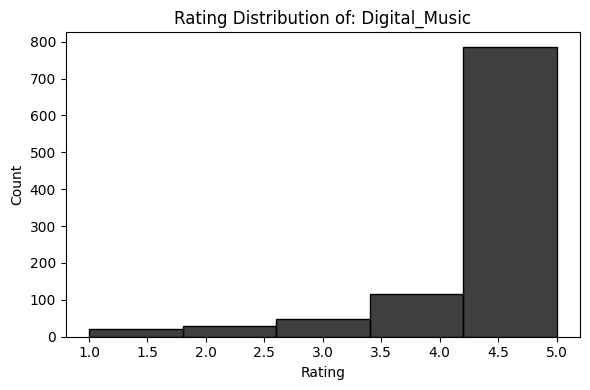

Clustering for category:Digital_Music


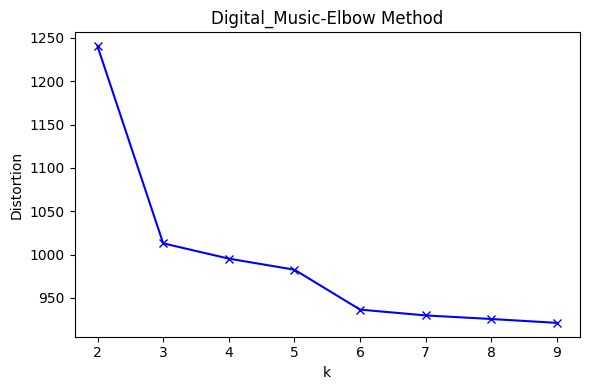

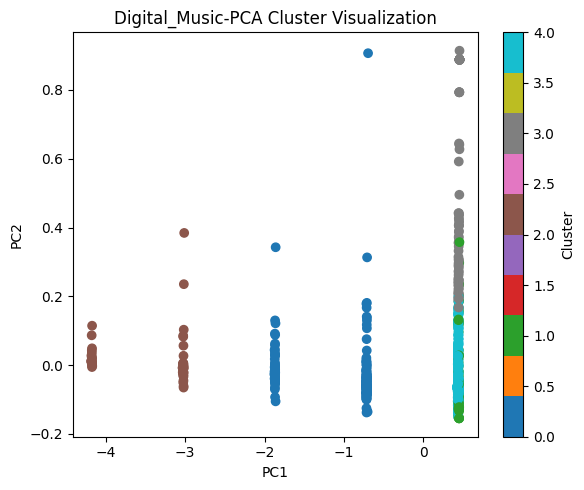

Silhouette Score forDigital_Music:0.0668
[✔] Αποθηκεύτηκε clustered->data/csv\Digital_Music_clustered.csv

Επεξεργασία κατηγορίας:Gift_Cards
Reading reviews from data/raw_json\Gift_Cards.jsonl
Reading meta data from data/raw_json\meta_Gift_Cards.jsonl
Reviews loaded:1000,Meta data loaded:1137
Saved 1000 merged rows to data/csv\Gift_Cards.csv
Αποθηκεύτηκε cleaned με sentiment->data/csv\Gift_Cards_cleaned.csv


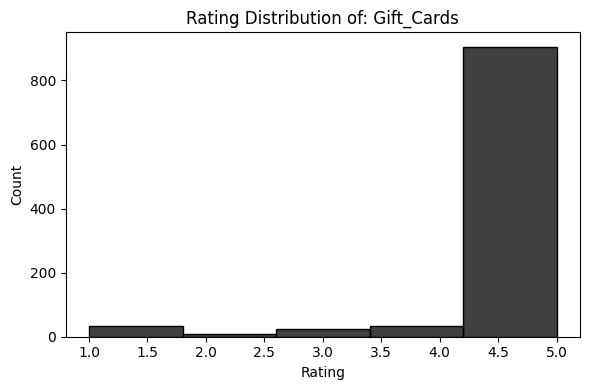

Clustering for category:Gift_Cards


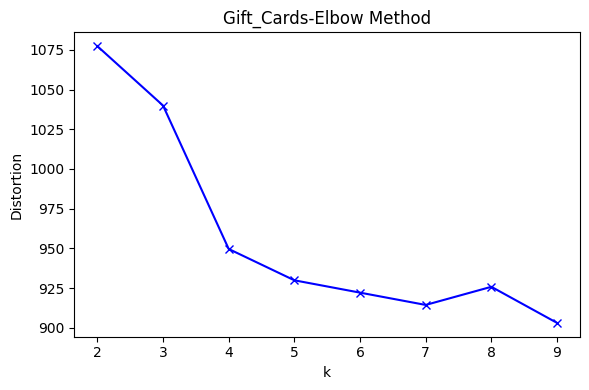

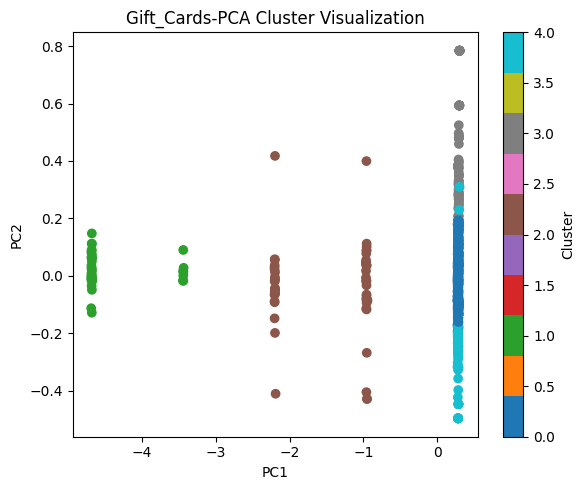

Silhouette Score forGift_Cards:0.0603
[✔] Αποθηκεύτηκε clustered->data/csv\Gift_Cards_clustered.csv
Full cleaned dataset saved->data/csv\cleaned_reviews.csv

Content-based recommendations (δείγμα από index 0)
      review_rating review_title      review_text  sentiment_score
1045            5.0            👍                👍           0.7000
1164            5.0          yum              yum           0.7000
1958            1.0         okay             okay           0.3679
1150            5.0    excelente  deposito rapido           0.7000
1883            5.0     adorable         adorable           0.8482

Classification Models
Κατανομή ετικετών:
sentiment_label
2    1974
1      26
Name: count, dtype: int64

[Naive Bayes]
10-Fold CV (train):
Precision:0.993
Recall:   0.500
F1-Score: 0.497
Accuracy: 0.987

Test set:
              precision    recall  f1-score   support

           1       1.00      0.00      0.00         5
           2       0.99      1.00      0.99       395

    accurac

In [11]:
RAW_DIR="data/raw_json"
CSV_DIR="data/csv"
review_files=[
    "Digital_Music.jsonl",
    "Gift_Cards.jsonl"
]
all_cleaned_dfs=[]
for review_file in review_files:
    category=review_file.replace(".jsonl","")
    review_path=os.path.join(RAW_DIR,review_file)
    meta_path=os.path.join(RAW_DIR,f"meta_{category}.jsonl")
    csv_path=os.path.join(CSV_DIR,f"{category}.csv")
    cleaned_path=os.path.join(CSV_DIR,f"{category}_cleaned.csv")
    print(f"\nΕπεξεργασία κατηγορίας:{category}")
    #Μετατροπή jsonl σε csv με συγχώνευση review και meta
    convert_jsonl_to_csv(review_path, meta_path, csv_path, max_rows=1000)
    #Έλεγχος αν το csv δημιουργήθηκε επιτυχώς
    if not os.path.exists(csv_path):
        print(f"Δεν βρέθηκε το αρχείο:{csv_path}")
        continue
    #Φόρτωση csv και καθαρισμός πεδίων
    df=pd.read_csv(csv_path)
    df_cleaned=clean_dataframe(df)
    #Αν αποτύχει ο καθαρισμός, προχωρά στην επόμενη κατηγορία
    if df_cleaned is None:
        print(f"Παράλειψη {category}:καθαρισμός απέτυχε")
        continue
    #Υπολογισμός sentiment score για κάθε κριτική
    df_cleaned['sentiment_score']=df_cleaned.apply(
        lambda row:compute_sentiment_score(row['review_text'],row['review_rating']),
        axis=1
    )
    #Αποθήκευση καθαρισμένων δεδομένων με sentiment
    df_cleaned.to_csv(cleaned_path,index=False)
    print(f"Αποθηκεύτηκε cleaned με sentiment->{cleaned_path}")
    #Εμφάνιση κατανομής βαθμολογιών
    plot_ratings_dist(df_cleaned, category)
    #Ομαδοποίηση προϊόντων (clustering)
    df_clustered=cluster_products(df_cleaned.copy(),category)
    cluster_path=os.path.join(CSV_DIR,f"{category}_clustered.csv")
    df_clustered.to_csv(cluster_path,index=False)
    print(f"[✔] Αποθηκεύτηκε clustered->{cluster_path}")

    #Προσθήκη στο γενικό σύνολο δεδομένων
    all_cleaned_dfs.append(df_cleaned)
#Τελική συνένωση όλων των κατηγοριών
if all_cleaned_dfs:
    all_data=pd.concat(all_cleaned_dfs,ignore_index=True)
    all_data_path=os.path.join(CSV_DIR,"cleaned_reviews.csv")
    all_data.to_csv(all_data_path,index=False)
    print(f"Full cleaned dataset saved->{all_data_path}")
    #Σύστημα συστάσεων
    print(f"\nContent-based recommendations (δείγμα από index 0)")
    recs=content_based_recommendations(all_data,0,top_k=5)
    print(recs)
    #Ταξινόμηση συναισθήματος
    print(f"\nClassification Models")
    run_classification_models()
else:
    print(" SFALMA Δεν υπάρχουν δεδομένα για classification/recommendation.")
